In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm import LGBMRegressor,log_evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


Each store contains many departments, and participants must project the sales **for each department in each store**. To add to the challenge, selected holiday markdown events are included in the dataset. 

In [2]:
train = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
test = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
stores = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
features = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
sample_submission = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

# INTRODUÇÃO

Neste notebook será desenvolvida a solução para problema proposto pela empresa Wallmart. O problema consiste em prever as vendas semanais (Weekly_Sales) de cada um dos depastamentos de 45 lojas localizadas em diferentes regiões, a partir de bases de dados disponibilizadas pela competição, contendo informações históricas.

**Analise exploratória:** Inicialmente sera feita uma analise exploratória para entender o tipo de info contida nas bases, capturar insights e embasar todas as decisões tomadas na etapa de tratamentos de dados. Foram disponivbilizadas as seguintes bases:
- Train.csv: Estes são os dados históricos para treinar o modelo.
- Teste.csv: Esta base é identica à base Train.csv, mas é referente a um periodo posterior e não possui a variavel resposta "Weekly_Sales". Esta é a base que de deveremos escorar para a competição.
- Store.csv: Este arquivo contem informação anonimizada das 45 lojas,indicando o Tipo e o tamanho da Loja.
- Features.csv: Este arquivo contem informação adicional relativa às lojas,e condições regionais para as determinadas datas
 

**Tratamento de dados:** A partir das conclusoes da etapa anterior os dados serão tratados criando, transformando, retirando variaveis, e inputando informações vazias quando necessário. 

**Modelagem de dados:** Com os dados tratados, inicia-se o processo de modelagem. Neste passo serão utilizadas as seguintes tecnicas:
- LASSO 
- DECISION TREE
- RANDOM FOREST
- LIGHGBM

**Avaliação :** Nesta etapa iremos comparar a performance dos modelos. Aquele com com melhor performance será utilizado para escorar a base Test.csv, e essas infos serão submetidas à competição. 

**Implantaçao :** Nesta passo fiz uma sugestão de codigo para implantação do modelo.

**Pontos de melhoria :** Considerações sobre o que poderia ser melhorado.


# ANALISE EXPLORATÓRIA


## Avaliando Base Train

train.csv

Nesta base estão contidas as informações:
- Store - Numero da Loja
- Dept - Numero do departamento
- Date - A semana
- Weekly_Sales - Vendas semanais para de um  departamento de uma loja
- IsHoliday - se a semana é uma semana de feriado

In [3]:
#Perguntas sobre a base Store
# 1.Qual tamanho?
# 2.Como é a base
# 3.As variaveis possuem missings?
# 4.Quais conclusões sobre a base

In [4]:
#1.Tamanho
train.shape

(421570, 5)

In [5]:
#2.Informação
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
#2.1 Incluir info de Datas
train['Date'] = pd.to_datetime(train['Date'])
train['Ano'] = (train.Date.dt.year).astype(int)
train['Mes'] = (train.Date.dt.month).astype(int)
train['Dia'] = (train.Date.dt.day).astype(int)
train['SemanaDoAno'] = ((train.Date.dt.isocalendar().week)*1.0).astype(int) 


In [7]:
train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Ano                      int64
Mes                      int64
Dia                      int64
SemanaDoAno              int64
dtype: object

In [8]:
#3.Missings?
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Ano             0
Mes             0
Dia             0
SemanaDoAno     0
dtype: int64

In [9]:
# 4.Quais conclusões sobre a base?
print("As datas vão de: "+ str(train.Date.min()) +", Até: "+ str(train.Date.max()))
print("Vendas mensais. Mínimo: " + train.Weekly_Sales.min().astype(str) +", Máximo: " + train.Weekly_Sales.max().astype(str))

As datas vão de: 2010-02-05 00:00:00, Até: 2012-10-26 00:00:00
Vendas mensais. Mínimo: -4988.94, Máximo: 693099.36


In [10]:
# 4.Quais conclusões sobre a base?
# Existe valor negativo no Target, faz sentido?
# Como está a distribuição?

train.Weekly_Sales.describe().T

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [11]:
#Qual a recorrencia de vendas negativas
print("Existem " + str(train["Weekly_Sales"].loc[train.Weekly_Sales<0].count()) + " casos de vendas negativas, que representam da base toda: " + str(round(train.loc[train.Weekly_Sales<0].shape[0]/train.shape[0],4)))

#Não parece ser dedada, aparenta ser algum tipo de prejuizo que a loja/departamento podem ter, não é comum mas acontece. 

Existem 1285 casos de vendas negativas, que representam da base toda: 0.003


In [12]:
# Estes prejuisos estão concentrados em alguma epoca, loja , departamento?
preju=train.loc[train.Weekly_Sales<0]
preju_group=preju[["Store","Weekly_Sales"]].groupby(["Store"]).count().sort_values(by="Weekly_Sales",ascending=False)
preju_group["percent"]=preju_group["Weekly_Sales"]/preju_group["Weekly_Sales"].sum()
preju_group.head(20)

,Weekly_Sales,percent
Store,,
35,124,0.096498
18,52,0.040467
10,50,0.038911
17,49,0.038132
15,45,0.035019
42,44,0.034241
22,41,0.031907
31,39,0.030350
39,38,0.029572


Os prejuizos não estao concentrados em uma loja especifica

In [13]:
preju_group1=preju[["Dept","Weekly_Sales"]].groupby(["Dept"]).count().sort_values(by="Weekly_Sales",ascending=False)
preju_group1["percent"]=preju_group1["Weekly_Sales"]/preju_group1["Weekly_Sales"].sum()
print("Dos " + str(len(preju_group1["Weekly_Sales"].unique())) +" departamentos com algum faturamento negativo, 5 representam " + str(round(preju_group1["Weekly_Sales"].head(5).sum()/preju_group1["Weekly_Sales"].sum(),2)) + " do total das recorencias")
preju_group1.head(5)


Dos 28 departamentos com algum faturamento negativo, 5 representam 0.58 do total das recorencias


,Weekly_Sales,percent
Dept,,
47,254,0.197665
18,180,0.140078
54,146,0.113619
19,87,0.067704
94,77,0.059922


Vale Verificar como está a distribuição das vendas, ao longo do tempo

In [14]:
#Plota Graficos de barra com metrica escolhida
import matplotlib.pyplot as plt
%matplotlib inline
def plot_por_target(df,var,resposta,metrica,ascending=0,segmentacao=""):
    
    base_agrup=df[[var,resposta]].groupby([var],as_index=False).agg({resposta:metrica})
    if ascending==1:
        base_agrup=base_agrup.sort_values(by=resposta,ascending=False)
    
    
    if segmentacao!="":
        data=[]
        base_agrup=df[[var,segmentacao,resposta]].groupby([var,segmentacao],as_index=False).agg({resposta:metrica})
        base_agrup["media"]=df[[var]].mean()
        import plotly.graph_objs as go
        for i in df[segmentacao].unique():
            base_agrup_1=base_agrup.loc[base_agrup[segmentacao]==i]
            trace = go.Bar(
            x = base_agrup_1[var],
            y = base_agrup_1[resposta],
            name = str(i))
            data.append(trace)
            layout = go.Layout(barmode = "group",
                               template='plotly_dark',
                               xaxis_title=var,
                               yaxis_title=resposta)
     
        fig1 = go.Figure(data = data, layout = layout)
        fig1.update_xaxes(dtick=1)

        return  fig1.show()
    else:
        fig,ax = plt.subplots(figsize=(16,8))
        base_agrup.plot.bar(x=var,y=resposta,ax=ax,label=var)
        return fig.show()


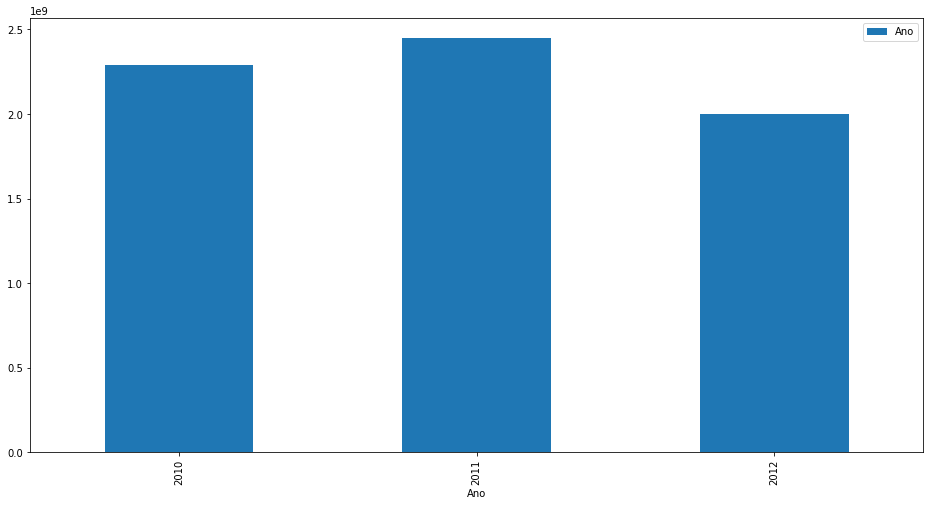

In [15]:
#Verifica como foi a soma de vendas nos anos
plot_por_target(train,"Ano","Weekly_Sales",sum,0)

Num primeiro momento parece que 2011 foi um ano melhor que 2010 e 2012

In [16]:
#Verifica como foi a soma de vendas nos meses
plot_por_target(train,"Mes","Weekly_Sales",sum,0,"Ano")

Mas depois de abrir as vendas por mes que faltam informações do começo de 2010 e final de 2012.

In [17]:
plot_por_target(train,"SemanaDoAno","Weekly_Sales",sum,0,"Ano")

Quando abrimos a informação de vendas por semana percebemos que (para os casos que possuem informação) há uma tendencia de aumento das vendas no final do ano principalmente entre o Thanksgiving e ao Natal. Após essas datas os níveis voltam a patamares até abaixo da média. Com excessão deste periodo as vendas não aparentam aumentar substancialmente. 

Como estão as vendas das lojas ao longo dos anos?

In [18]:
plot_por_target(train,"Store","Weekly_Sales",sum,0,"Ano")

Existe uma relativa consistencia no valor de vendas das Lojas quando comparamos os 3 anos. Aqui podemos ordenar as lojas por vendas.

como estão as vendas dos departamentos ao longo dos anos?

In [19]:
plot_por_target(train,"Dept","Weekly_Sales",sum,0,"Ano")

Existe uma relativa consistencia no valor de vendas dos departamentos quando comparamos os 3 anos. Aqui podemos ordenar os departamentos por vendas.

In [20]:
#Esta função cria um grafico de boxplot 
def boxplot(df,var,resposta,segmentacao,outliers=True):
    plt.figure(figsize = (20,6))
    if segmentacao!="":
        fig = sns.boxplot(x = segmentacao
                          ,y = resposta
                          ,data = df[[segmentacao,resposta,var]]
                          ,showfliers = outliers
                          ,hue = var
                     )
    else:
        fig = sns.boxplot(x = var
                          ,y = resposta
                          ,data = df[[var,resposta]]
                          ,showfliers = outliers
                     )
    return plt.show()

Agora iremos avaliar a variavel IsHoliday para ver como ela influencia nas vendas das lojas.

In [21]:
# boxplot(train,"IsHoliday","Weekly_Sales","Store",True)

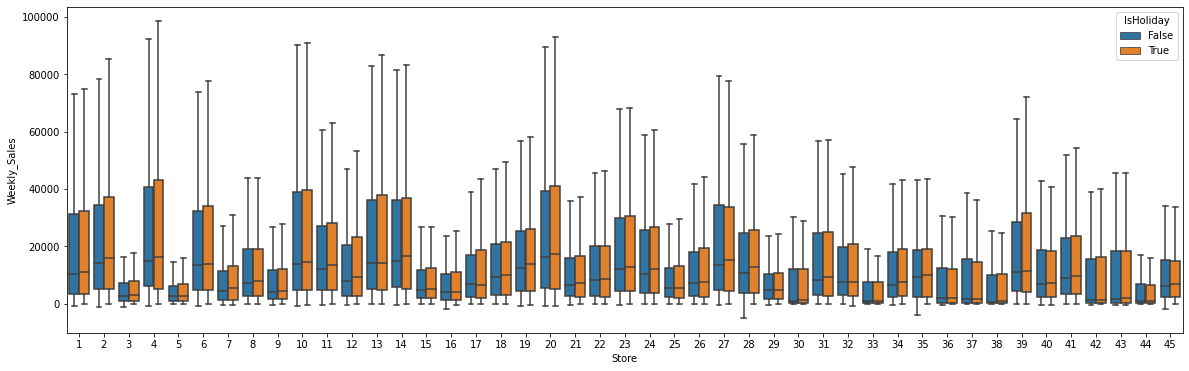

In [22]:
boxplot(train,"IsHoliday","Weekly_Sales","Store",False)

De forma geral os Feriados possuem um impacto marginalmente positivo nas vendas das lojas

Como está a relação de departamentos com o Target?

Agora iremos avaliar a variavel IsHoliday para ver como ela influencia nas vendas nos departamentos.

In [23]:
# boxplot(train,"IsHoliday","Weekly_Sales","Dept",True)

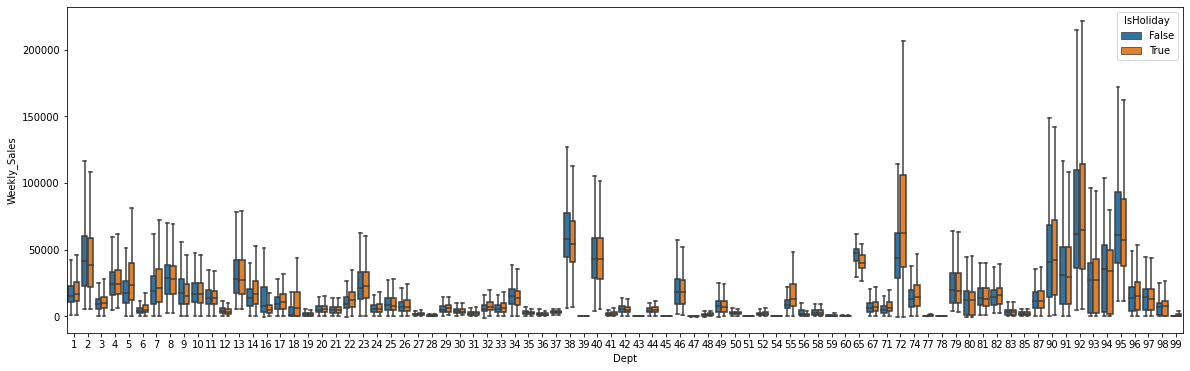

In [24]:
#Retirando os ouliers
boxplot(train,"IsHoliday","Weekly_Sales","Dept",False)

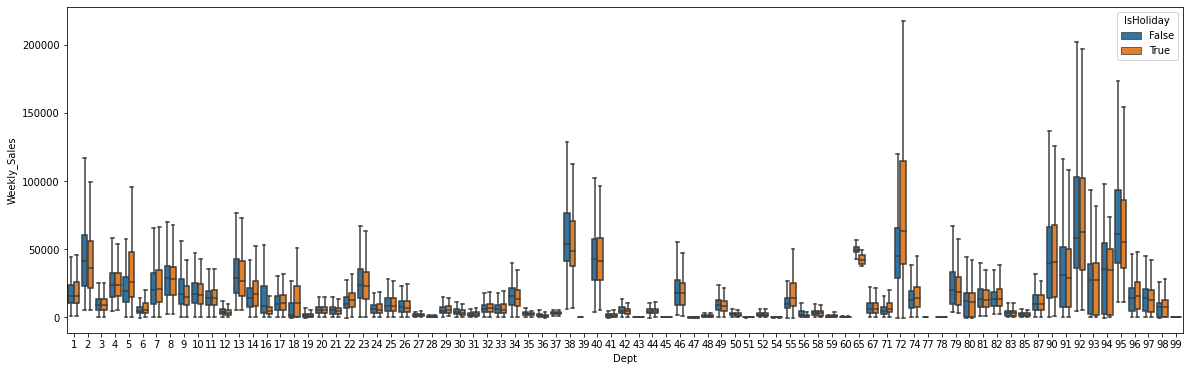

In [25]:
boxplot(train[train["Ano"]==2010],"IsHoliday","Weekly_Sales","Dept",False)

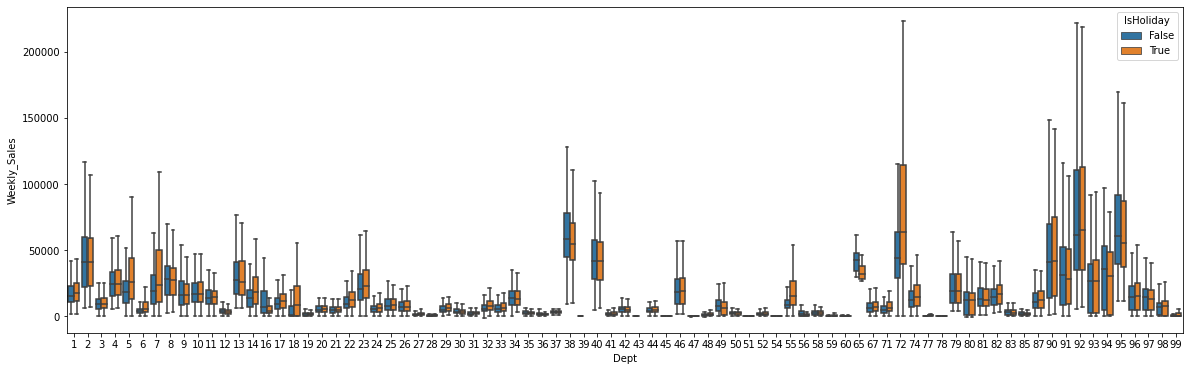

In [26]:
boxplot(train[train["Ano"]==2011],"IsHoliday","Weekly_Sales","Dept",False)

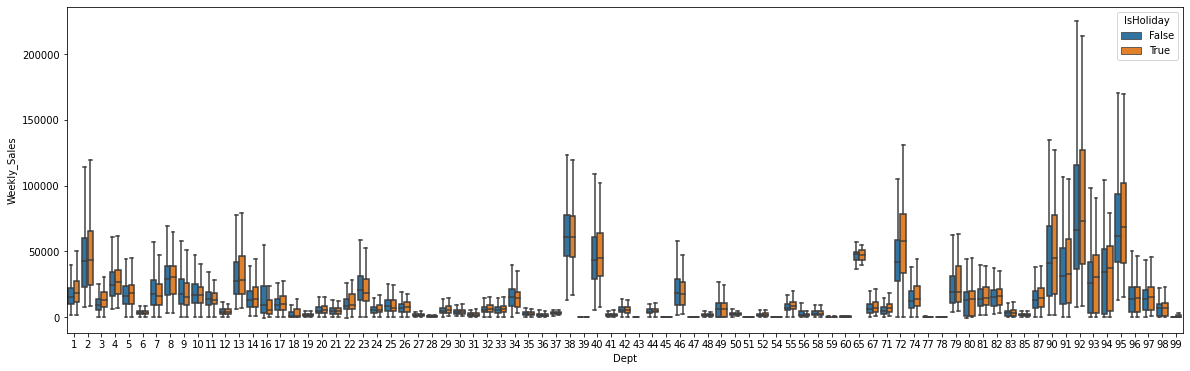

In [27]:
boxplot(train[train["Ano"]==2012],"IsHoliday","Weekly_Sales","Dept",False)

De forma geral os feriados não afetam todos os departamentos de forma expressiva. No entando podemos ressaltar o departamento 72 que é altamente impactado pelos feriados (mais do que os outros). Nos anos de 2010 e 2011 este departamento apresentou um distribuição superior  quando comparamos "feriados" e não "feriados". Observamos 2012, este departamento ficou abaixo do esperado em comparação aos outros anos pois não há na base, o periodo que compreende o Thanxgiving e o Natal. 


##  Avaliando a Base Teste e Sample Submission

In [28]:
test.shape

(115064, 4)

In [29]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [30]:
print("As datas da base teste vão de: "+ str(test.Date.min()) +", até: "+ str(test.Date.max()))

As datas da base teste vão de: 2012-11-02, até: 2013-07-26


In [31]:
sample_submission.shape

(115064, 2)

In [32]:
sample_submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


Para submissão do problema será necessário cruzar as features à base teste e depois trazerestas infos na base sample_submission

## Avaliando a Base Store

In [33]:
#Perguntas sobre a base Store
# 1.Qual tamanho?
# 2.Como é a base
# 3.As variaveis possuem missings?
# 4.Quais conclusões sobre a base

In [34]:
#1.Tamanho
stores.shape

(45, 3)

In [35]:
#2. Como é a base
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [36]:
#3. Missings
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [37]:

stores.groupby(["Type"]).agg({"Size":[min,"mean", "median",max,"std"],"Type":"count"})
#tipo parece ter a ver com o porte da loja

Size                                                 Type
        min           mean    median     max           std count
Type                                                            
A     39690  177247.727273  202406.0  219622  49392.621098    22
B     34875  101190.705882  114533.0  140167  32371.137916    17
C     39690   40541.666667   39910.0   42988   1304.145033     6

#Existe uma segmentação das lojas. Aparentemente pode ter relação com o tamanho, mas deve ser avaliada a relação com as vendas.

Cruzando train e store para avaliar tamanho e tipo em relação à variavel resposta

In [38]:
train_store=pd.merge(train,stores,on=["Store"],how="left")

In [39]:
train_store.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Ano,Mes,Dia,SemanaDoAno,Type,Size
0,1,1,2010-02-05,24924.50,False,2010,2,5,5,A,151315
1,1,1,2010-02-12,46039.49,True,2010,2,12,6,A,151315
2,1,1,2010-02-19,41595.55,False,2010,2,19,7,A,151315
3,1,1,2010-02-26,19403.54,False,2010,2,26,8,A,151315
4,1,1,2010-03-05,21827.90,False,2010,3,5,9,A,151315


In [40]:
# boxplot(train_store,"Ano","Weekly_Sales","Type",True)

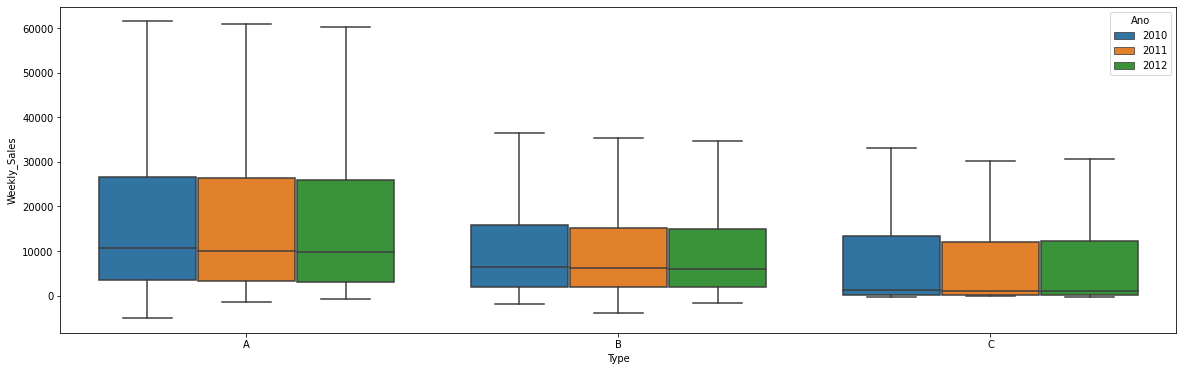

In [41]:
boxplot(train_store,"Ano","Weekly_Sales","Type",False)

O "Type" da loja aparenta ter relação com as vendas. Não sabemos exatamente o que é a variavel, mas podemos assumir que A > B > C Quando comparamos as medianas apesar de B apresentar maior aplitude nos outliers.


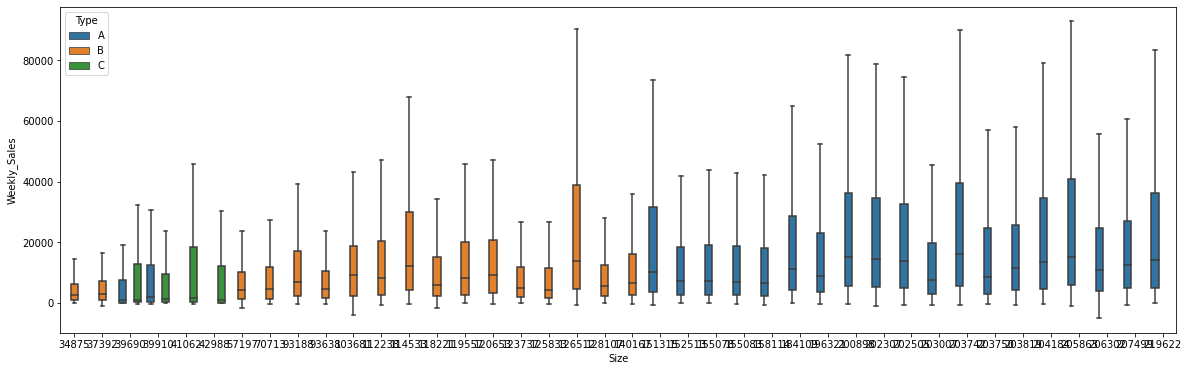

In [42]:
boxplot(train_store,"Type","Weekly_Sales","Size",False)

In [43]:
#boxplot(train_store,"Type","Weekly_Sales","Size",True)

De forma geral os dados indicam que pode haver uma relação entre tamanho x tipo de loja x vendas

## Avaliando a Base Features



features.csv

Este arquivo contém dados adicionais relacionados à loja, departamento e atividade regional para as datas especificadas. Ele contém os seguintes campos:

Store - O número da loja
Date - A semana
Temperatura - temperatura média na região
Fuel_Price - custo do combustível na região
MarkDown1-5 - dados anônimizados relacionados a descontos promocionais que o Walmart está executando. Os MarkDown só estão disponíveis após novembro de 2011 e não estão disponíveis para todas as lojas o tempo todo. Qualquer valor ausente é marcado com um NA.
CPI - O índice de preços ao consumidor (Inflação)
Desemprego - A taxa de desemprego
IsHoliday - Se a semana é uma semana de feriado
Por conveniência, os quatro feriados se enquadram nas semanas a seguir no conjunto de dados (nem todos os feriados estão nos dados):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [44]:
#Perguntas sobre a base Store
# Qual tamanho?
# Que informação há lá
# As variaveis possuem missings?
# Quais conclusões sobre a base

In [45]:
print("As datas da base features vão de: "+ str(features.Date.min()) +", até: "+ str(features.Date.max()))

As datas da base features vão de: 2010-02-05, até: 2013-07-26


In [46]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [47]:
# Missings da base
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

Abaixo quero ter uma visão geral de como se comportam as variaveis contidas na base feature em relação à store, dado que estas variaveis estão associadas com o região de localização das lojas.

In [48]:
features[["Store","Temperature","Fuel_Price","CPI","Unemployment"]].groupby(["Store"]).\
                                                                    agg({"Temperature":"median",\
                                                                        "Fuel_Price":"median",\
                                                                        "CPI":"median",\
                                                                        "Unemployment":"median"})

,Temperature,Fuel_Price,CPI,Unemployment
Store,,,,
1,67.510,3.3540,216.041053,7.742
2,67.025,3.3540,215.694438,7.852
3,71.865,3.3540,219.397287,7.343
4,63.175,3.3550,129.430600,5.644
5,69.065,3.3540,216.603308,6.465
6,69.595,3.3540,217.579751,6.855
7,38.625,3.4790,194.741971,8.595
8,62.085,3.3540,219.444244,6.262
9,67.315,3.3540,219.629784,6.380


Existem diferenças nas medianas entre as lojas, vale avaliar as distribuições

In [49]:
features["Anomesdia"]=pd.to_datetime(features['Date']).dt.strftime('%Y%m%d').astype(int)

Nos gráficos seguintes avaliaremos como estão distribuidas para cada Loja, as variaveis: CPI, Unemployment, Fuel_Price, Temperature.

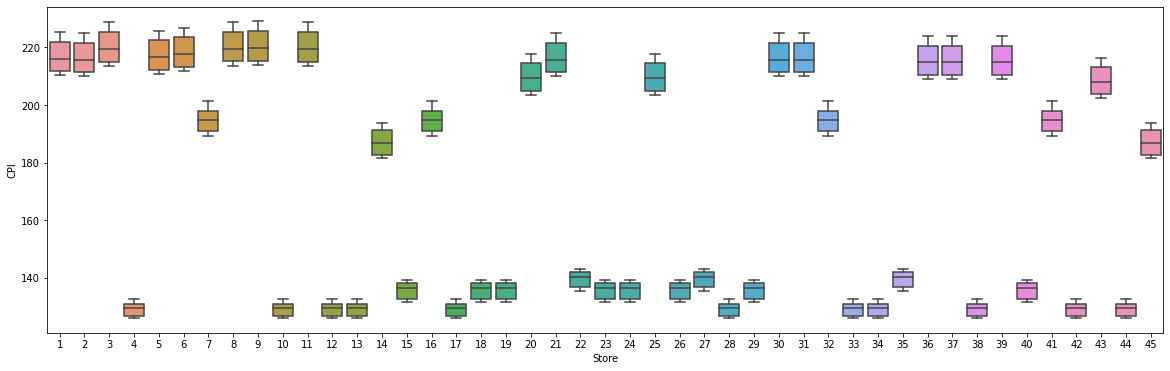

In [50]:
boxplot(features,"Store",'CPI',"")

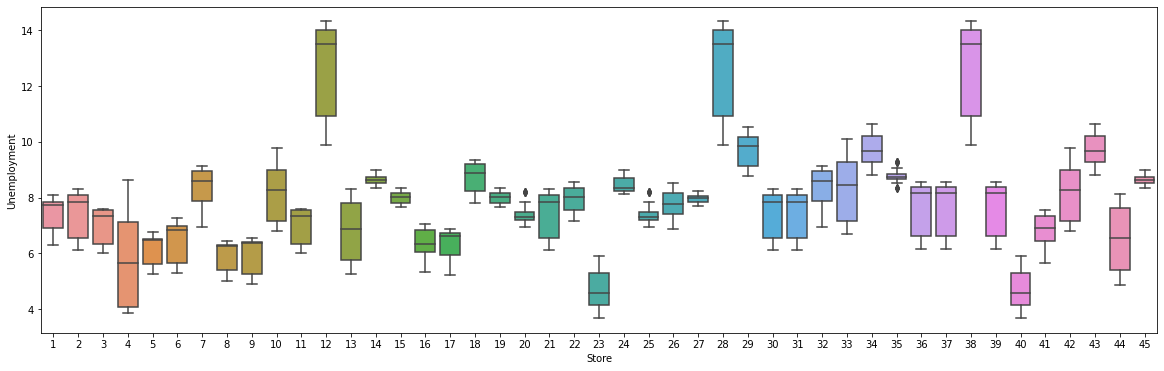

In [51]:
boxplot(features,"Store",'Unemployment',"")

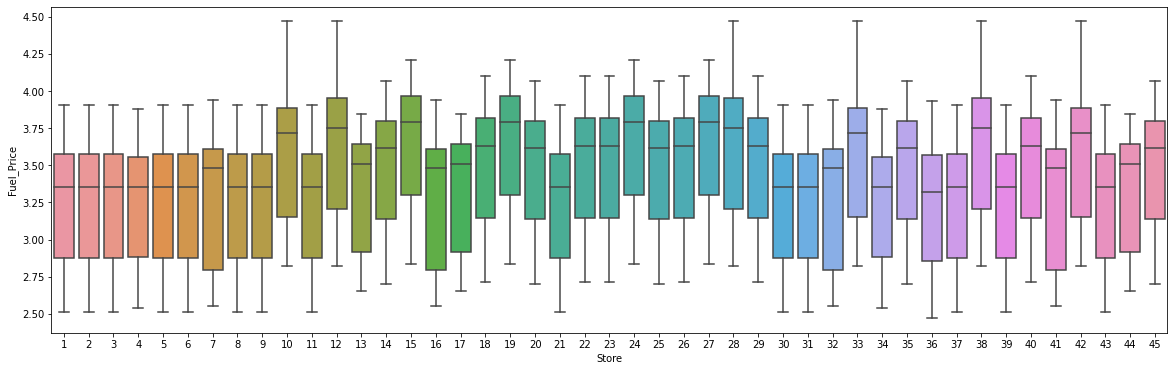

In [52]:
boxplot(features,"Store",'Fuel_Price',"")

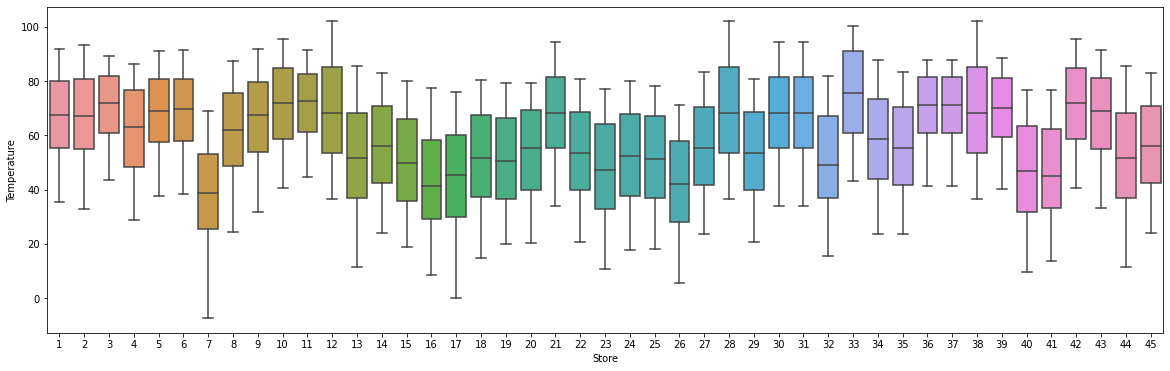

In [53]:
boxplot(features,"Store",'Temperature',"")

Cada loja aparentemente esta localizada em uma região especifica com suas peculiaridades de temperatura, inflação, desemprego e preço de combustível

Temperaturas frias podem ter maior impacto em regiões com medianas de temperatura mais quentes.

Faz sentido testar se variações dentro das regiões (Normalizar por região) possuem correlação com a variavel resposta.

In [54]:
#Normaliza os valores para cada agrupamento pelo desvio padrão e imputa missing pela mediana (menor influencia por outliers)
def normaliza_dentro_grupo(df,var_num,grupo):
    df_final=pd.DataFrame()
    for idx,i in enumerate(df[grupo].unique()):
        df1=df[df[grupo]==i][var_num].fillna(df_final.median())
        df1=(df1-df1.mean())/df1.std()
        df_final=df_final.append(pd.DataFrame(df1))
    return df_final.sort_index()
features["Unemployment_norm"]=normaliza_dentro_grupo(features,"Unemployment","Store")
features["CPI_norm"]=normaliza_dentro_grupo(features,"CPI","Store")
features["Temperature_norm"]=normaliza_dentro_grupo(features,"Temperature","Store")
features["Fuel_price_norm"]=normaliza_dentro_grupo(features,"Fuel_Price","Store")

In [55]:
features[["Unemployment","CPI","Temperature","Fuel_Price"]].agg({"Unemployment":["mean","median"],"CPI":["mean","median"],"Temperature":["mean","median"],"Fuel_Price":["mean","median"]})

,Unemployment,CPI,Temperature,Fuel_Price
mean,7.826821,172.460809,59.356198,3.405992
median,7.806000,182.764003,60.710000,3.513000


In [56]:
#Imputando missings pela mediana (menor influencia por outliers)
features['Temperature'].fillna(features['Temperature'].median(), inplace=True)
features['Fuel_Price'].fillna(features['Fuel_Price'].median(), inplace=True)
features['CPI'].fillna(features['CPI'].median(), inplace=True)
features['Unemployment'].fillna(features['Unemployment'].median(), inplace=True)
features.isnull().sum()

Store                   0
Date                    0
Temperature             0
Fuel_Price              0
MarkDown1            4158
MarkDown2            5269
MarkDown3            4577
MarkDown4            4726
MarkDown5            4140
CPI                     0
Unemployment            0
IsHoliday               0
Anomesdia               0
Unemployment_norm     585
CPI_norm              585
Temperature_norm        0
Fuel_price_norm         0
dtype: int64

In [57]:
# Transformando em datetime para cruzar com a base train_store

features["Date"]=pd.to_datetime(features["Date"])

#Cruza a base Trains Store com a base Features

base_treino=pd.merge(train_store,features.drop(columns=["IsHoliday"],axis=1,errors="ignore"),left_on=["Date","Store"],right_on=["Date","Store"],how="left")

In [58]:
#Os valores missing nos markdownsserão substituidos pelo valor 0, trataremos como se a ausencia da info indicasse que não houveram de ações promocionais.
base_treino['MarkDown1'].fillna(0, inplace=True)
base_treino['MarkDown2'].fillna(0, inplace=True)
base_treino['MarkDown3'].fillna(0, inplace=True)
base_treino['MarkDown4'].fillna(0, inplace=True)
base_treino['MarkDown5'].fillna(0, inplace=True)
base_treino.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Ano                  0
Mes                  0
Dia                  0
SemanaDoAno          0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1            0
MarkDown2            0
MarkDown3            0
MarkDown4            0
MarkDown5            0
CPI                  0
Unemployment         0
Anomesdia            0
Unemployment_norm    0
CPI_norm             0
Temperature_norm     0
Fuel_price_norm      0
dtype: int64

Agora iremos avaliar as variaveis e suas correspondentes normalizadas, da base features em relação às vendas 

In [59]:
def scatter(dataset, var1,var1_norm,var2,segmentacao):

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

    if segmentacao=="":
        sns.scatterplot(data=dataset[[var1,var2]], 
                        x=var1, y=var2,ax=ax1)

        sns.scatterplot(data=dataset[[var1_norm,var2]], 
                        x=var1, y=var2,ax=ax2)
    else:

        sns.scatterplot(data=dataset[[var1,var2,segmentacao]], 
                        x=var1, y=var2, 
                        hue= segmentacao,ax=ax1)
        sns.scatterplot(data=dataset[[var1_norm,var2,segmentacao]], 
                        x=var1_norm, y=var2, 
                        hue= segmentacao,ax=ax2)
    return 

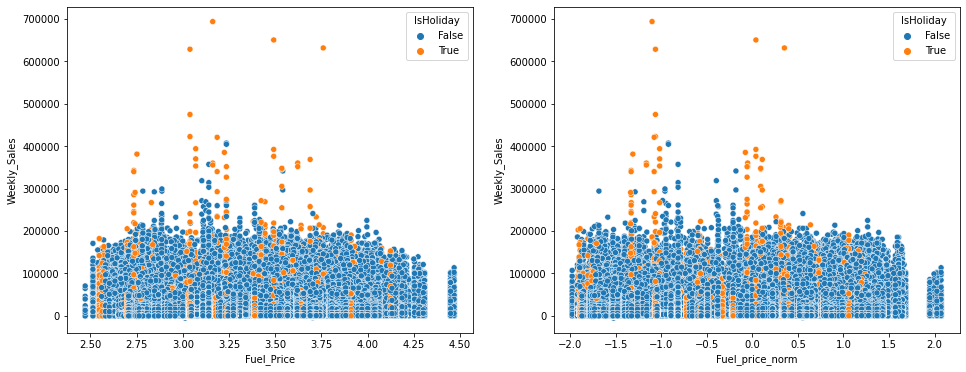

In [60]:
scatter(base_treino, 'Fuel_Price',"Fuel_price_norm","Weekly_Sales","IsHoliday")


Fuel_price não apresenta uma correlação evidente com a variavel resposta, assim como sua correspondente normalizada "Fuel_price_norm"

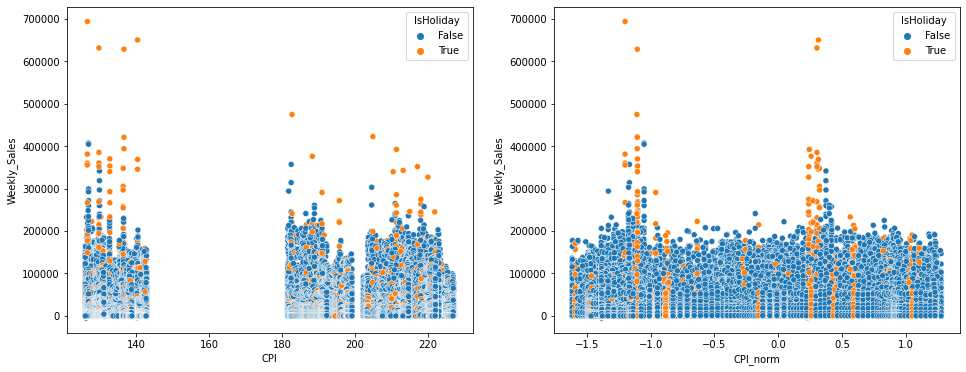

In [61]:
scatter(base_treino, 'CPI',"CPI_norm","Weekly_Sales","IsHoliday")

CPI não apresenta uma correlação evidente com a variavel resposta, assim como sua correspondente normalizada "CPI_norm"

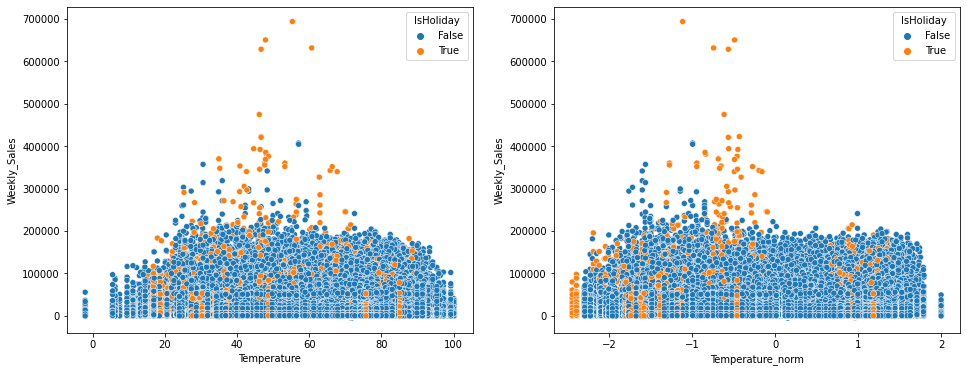

In [62]:
scatter(base_treino, 'Temperature',"Temperature_norm","Weekly_Sales","IsHoliday")


Temperatura apresenta uma concentração em uma região especifica (entre 20F e 80F) e pode apresentar uma correlação com a variavel resposta. Observando pela Temperatura normalizada não há uma evidente alteração nas vendas quando as temperaturas ficam muito distantes da média

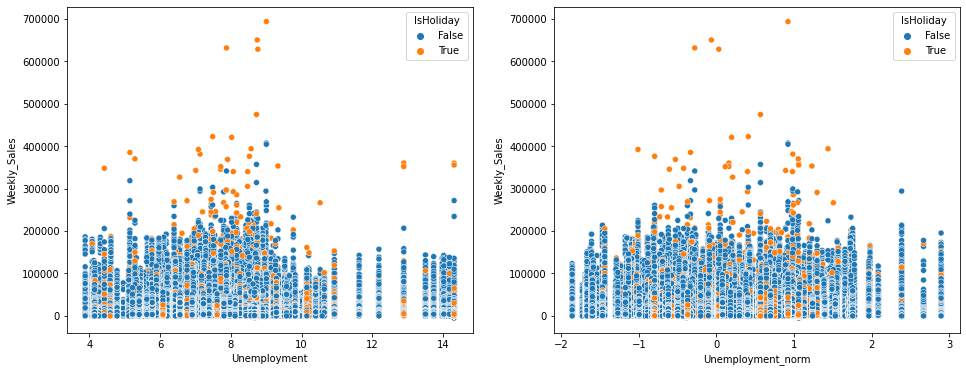

In [63]:
scatter(base_treino,'Unemployment',"Unemployment_norm","Weekly_Sales","IsHoliday")

Unemployment não apresenta uma correlação evidente com a variavel resposta, assim como sua correspondente normalizada "Unemployment_norm".

# TRATAMENTO DOS DADOS

Nos passos seguintes será feita a recategorização das variaveis Store, Dept, e Type ordenando pela variavel resposta. Para Store e Dept

In [64]:
def cat_por_target(df,var,resposta,metrica):
    base_group=((df[[var,resposta]].groupby([var], as_index=False).agg({resposta:metrica}).sort_values(by=resposta,ascending=False)).reset_index(drop=True)).reset_index()
    retorno = dict((v, k) for k, v in enumerate(base_group[var].astype(str).unique(), 1))
    return retorno

In [65]:
str(cat_por_target(base_treino,"Dept","Weekly_Sales","median"))

"{'92': 1, '95': 2, '38': 3, '65': 4, '72': 5, '40': 6, '2': 7, '90': 8, '94': 9, '91': 10, '8': 11, '13': 12, '93': 13, '4': 14, '23': 15, '79': 16, '7': 17, '46': 18, '5': 19, '10': 20, '9': 21, '1': 22, '34': 23, '82': 24, '96': 25, '97': 26, '11': 27, '14': 28, '81': 29, '74': 30, '80': 31, '87': 32, '17': 33, '3': 34, '22': 35, '55': 36, '25': 37, '49': 38, '16': 39, '98': 40, '26': 41, '67': 42, '32': 43, '33': 44, '24': 45, '42': 46, '20': 47, '71': 48, '29': 49, '21': 50, '44': 51, '6': 52, '12': 53, '30': 54, '37': 55, '83': 56, '35': 57, '58': 58, '50': 59, '31': 60, '85': 61, '52': 62, '56': 63, '36': 64, '19': 65, '27': 66, '41': 67, '18': 68, '48': 69, '28': 70, '59': 71, '60': 72, '77': 73, '99': 74, '54': 75, '47': 76, '45': 77, '51': 78, '39': 79, '78': 80, '43': 81}"

In [66]:
#Fillna 40 pois qualquer valor missing (se for criado um novo departamento ou se houver algum problema no envio desta variavel) 
# será considerado como havendo valor intermediário de Vendas. 
base_treino["Dept_cat"]=(base_treino["Dept"].astype(str).map(cat_por_target(base_treino,"Dept","Weekly_Sales","median")).fillna(40)).astype(float)

In [67]:
str(cat_por_target(base_treino,"Store","Weekly_Sales","median"))

"{'20': 1, '14': 2, '4': 3, '2': 4, '13': 5, '10': 6, '6': 7, '27': 8, '19': 9, '11': 10, '23': 11, '39': 12, '28': 13, '24': 14, '1': 15, '18': 16, '35': 17, '41': 18, '31': 19, '22': 20, '12': 21, '32': 22, '8': 23, '26': 24, '40': 25, '17': 26, '21': 27, '34': 28, '45': 29, '25': 30, '15': 31, '29': 32, '7': 33, '9': 34, '16': 35, '3': 36, '5': 37, '36': 38, '43': 39, '37': 40, '42': 41, '30': 42, '33': 43, '44': 44, '38': 45}"

In [68]:
#Fillna 22 pois qualquer valor missing (se for criado um novo departamento ou se houver algum problema no envio desta variavel) 
# será considerado como havendo valor intermediário de Vendas. 
base_treino["Store_cat"]=(base_treino["Store"].astype(str).map(cat_por_target(base_treino,"Store","Weekly_Sales","median")).fillna(22)).astype(float)

In [69]:
str(cat_por_target(base_treino,"Type","Weekly_Sales","median"))

"{'A': 1, 'B': 2, 'C': 3}"

In [70]:
#Aplica recategorização à variavel Type
#Neste caso o imputaremos o missing com o tipo de loja mais comum (B) 
base_treino["Type_cat"]=(base_treino["Type"].astype(str).map(cat_por_target(base_treino,"Type","Weekly_Sales","median")).fillna(2)).astype(float)

In [71]:
#Transforma a variavel IsHoliday em numérico
base_treino['IsHoliday_cat'] = base_treino['IsHoliday'].apply(lambda x: 1 if x else 0)
base_treino['IsHoliday_cat'].value_counts()

0    391909
1     29661
Name: IsHoliday_cat, dtype: int64

In [72]:
#Estas variavel conta quantos dias faltam para o Thanksgiving e para o Natal
base_treino['Dias_p_Thansksgiving'] = (pd.to_datetime(base_treino["Ano"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(base_treino["Date"], format="%Y-%m-%d")).dt.days.astype(float)
base_treino['Dias_p_Natal'] = (pd.to_datetime(base_treino["Ano"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(base_treino["Date"], format="%Y-%m-%d")).dt.days.astype(float)

In [73]:
#Esta variavel marca uma flag para cada feriado
base_treino['SuperBowlWeek'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 6 else 0)
base_treino['LaborDay'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 35 else 0)
base_treino['Tranksgiving'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 46 else 0)
base_treino['Christmas'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 51 else 0)
base_treino["THX_GVN_TO_XMAS"]=base_treino['SemanaDoAno'].apply(lambda x: 1 if (x>46) & (x<52)  else 0)

In [74]:
#Unifica os markdowns em uma variavel só
base_treino['MarkdownsSum'] = base_treino['MarkDown1'] + base_treino['MarkDown2'] + base_treino['MarkDown3'] + base_treino['MarkDown4'] + base_treino['MarkDown5'] 

## Seleção de Variáveis

Nesta etapa iremos avaliar a correlação das variaveis entre si e com a variável resposta. Para isso contrui uma função que plota as correlações e aponta as variaveis com alta correlação

In [75]:
#Função para plotar a matriz de correlação
def print_correlation_matrix(df,explicativas,target,corr_max=0.75):

    sns.set(style="white")
    corr = round(df[explicativas+[target]].corr(),3)
    corr_abs = df[explicativas+[target]].corr().abs()
    upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
    high_corr = [column for column in upper.columns if any(upper[column]>=corr_max)]
    

    f, ax = plt.subplots(figsize=(21, 21))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    
    sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5},annot_kws={"size":12})
    sns.set(font_scale=2)
    plt.show()
    return high_corr

In [76]:
base_treino.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Ano', 'Mes',
       'Dia', 'SemanaDoAno', 'Type', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Anomesdia', 'Unemployment_norm', 'CPI_norm',
       'Temperature_norm', 'Fuel_price_norm', 'Dept_cat', 'Store_cat',
       'Type_cat', 'IsHoliday_cat', 'Dias_p_Thansksgiving', 'Dias_p_Natal',
       'SuperBowlWeek', 'LaborDay', 'Tranksgiving', 'Christmas',
       'THX_GVN_TO_XMAS', 'MarkdownsSum'],
      dtype='object')

In [77]:
#Estou dropando estas vars da lista pois umas eu fiz recategorização e outras não fazem sentido estarem na analise
vars_explicativas=[

#        'Store', 'Dept','IsHoliday', 'Type', 'Ano', 'Date', 'Weekly_Sales', 'Anomesdia', 

       'Mes',
       'Dia', 'SemanaDoAno', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Dept_cat', 'Store_cat', 'Type_cat',
       'IsHoliday_cat', 'Dias_p_Thansksgiving', 'Dias_p_Natal',
       'SuperBowlWeek', 'LaborDay', 'Tranksgiving', 'Christmas',
       'THX_GVN_TO_XMAS', 'MarkdownsSum',
       'Unemployment_norm', 'CPI_norm',
       'Temperature_norm', 'Fuel_price_norm']
  

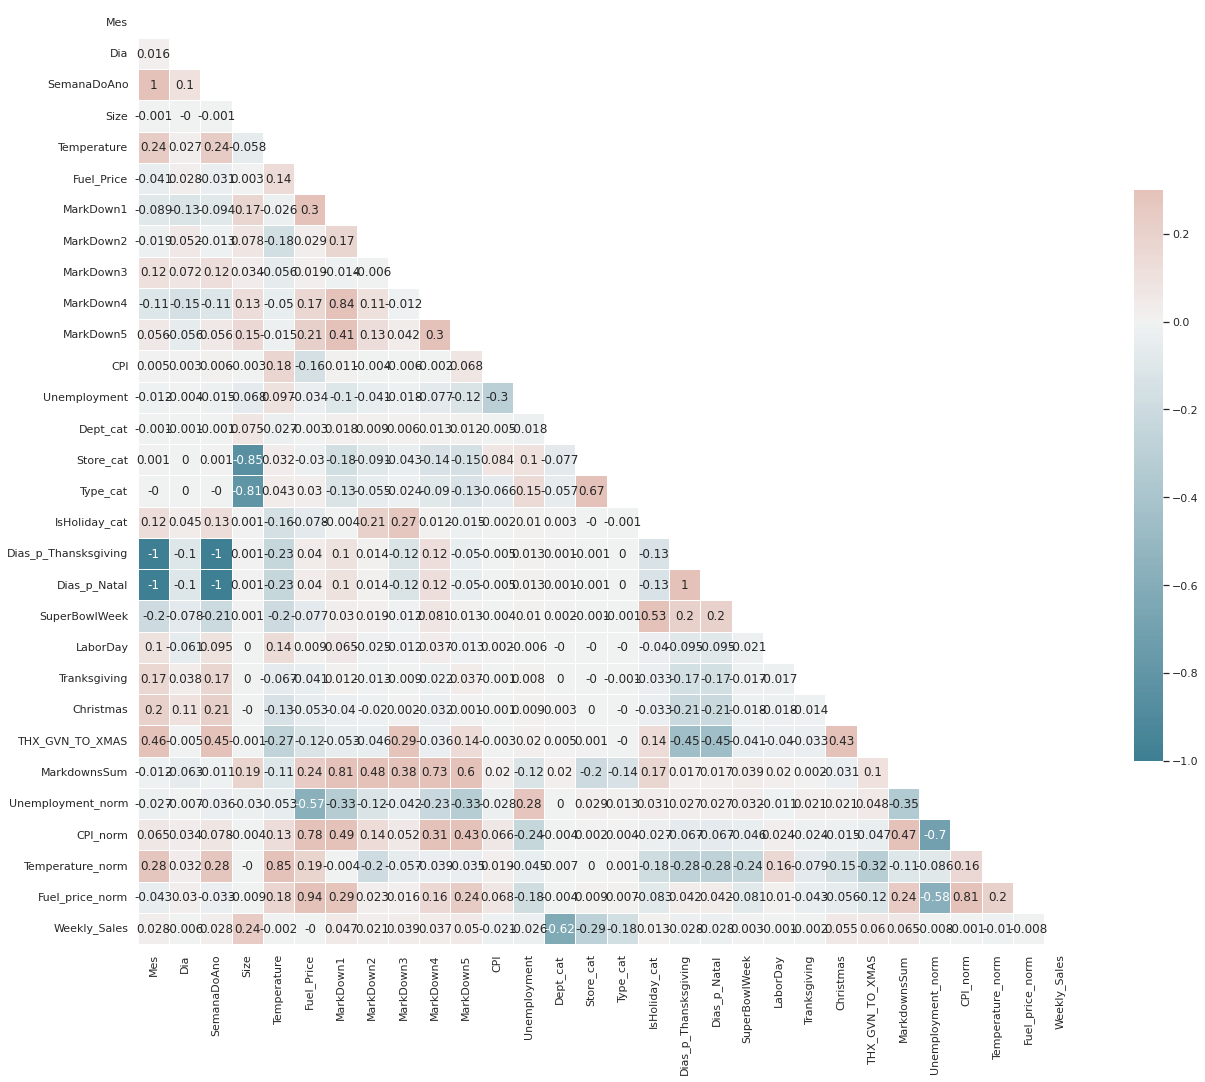

['SemanaDoAno',
 'MarkDown4',
 'Store_cat',
 'Type_cat',
 'Dias_p_Thansksgiving',
 'Dias_p_Natal',
 'MarkdownsSum',
 'CPI_norm',
 'Temperature_norm',
 'Fuel_price_norm']

In [78]:
high_corr=print_correlation_matrix(base_treino,vars_explicativas,'Weekly_Sales',0.75)
high_corr

As variaveis acima estão altamente correlacionadas com outras. Aqui o critério adotado foi manter a variavel que tiver maior correlação com o target.
Obs: Um ponto de melhoria aqui seria automatizar a decisão de dropar, dentre as com alta correlação, a que possuir menor correlação com a var respota.  

In [79]:
vars_explicativas2=vars_explicativas=[
    
#        'Store', 'Dept', 'IsHoliday','Type'     Estas vars foram transformadas e serão excluidas
#      'Ano',  'Date'                            Esta var não faz sentido deixar
#       'Weekly_Sales','Anomesdia',              Var resposta
       'Mes',
       'Dia', 
#        'SemanaDoAno', 
#       'Type', 
#      'Size',
       'Temperature',
       'Fuel_Price',
       'CPI', 
       'Unemployment',
       'Dept_cat', 'Store_cat', 'Type_cat',
       'IsHoliday_cat', 
#        'Dias_p_Thansksgiving', 'Dias_p_Natal',
       'SuperBowlWeek', 'LaborDay', 'Tranksgiving', 'Christmas',
       'THX_GVN_TO_XMAS']

Size é altamente correlacionada com Store e Tipo e será retirada.
SemanaDoAno é altamente correlacionada com Mes e será retirada.
Dias_p_Thansksgiving e Dias_p_Natal são altamente correlacionada com Mes e dia e serão retirados.
Os 'MarkDown' de 1 a 5 não possuem correlação significante com 'Weekly_Sales' e possuem muitos missings principalmente antes de 2011-11. Se eu fosse manter os markdowns faria sentido treinar o modelo selecionando a base apartir de 2011-11. No entanto perderiamos informações valiosas das variaveis que possuem maior correlação com o target. Por isso decidi retir-las da base.
A variavel Unemployment_norm norm possui baixissima correlação com a variavel resposta utilizaremos somente Unemployment.
A variavel CPI_norm norm possui baixissima correlação com a variavel resposta utilizaremos somente CPI.
As variaveis Temperature_norm e Fuel_price_norm possuem baixa correlação com o target, no entanto maior que suas correspondentes não normalizadas(Temperature, Fuel). Pensando pelo lado de implantação, não valeria a pena manter duas variaveis com baixa correlação mas que demandariam implantação de uma base com histórico para calcular média e desvio padrao.


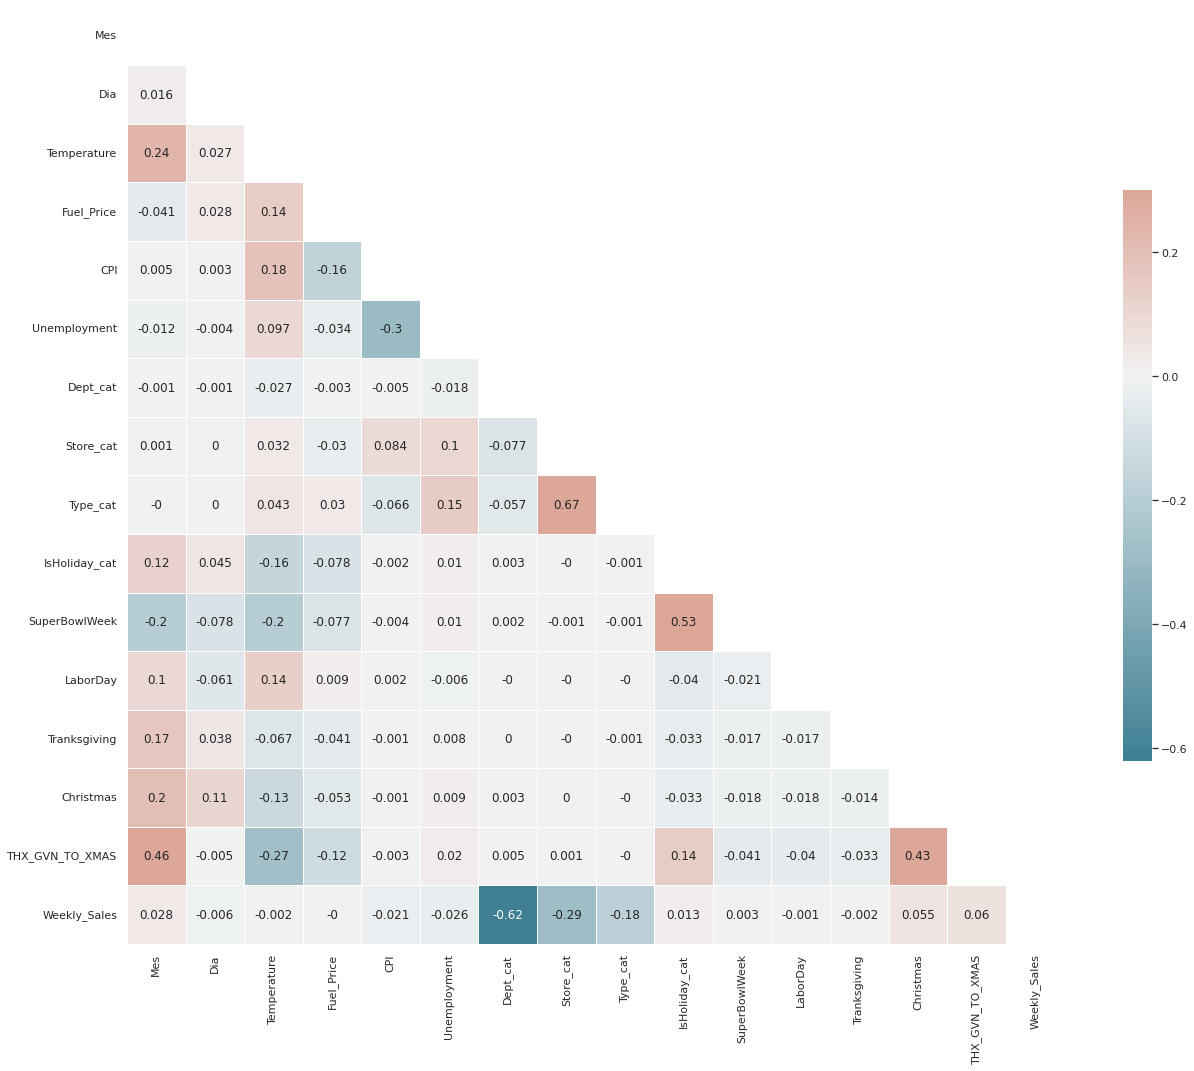

[]

In [80]:
#Apos a retirada das variaveis
high_corr_after_cut=print_correlation_matrix(base_treino,vars_explicativas2,'Weekly_Sales',0.75)
high_corr_after_cut

Aqui observamos que não há mais nenhuma variavel com correlação acima do limite estipulado então utilizaremos estas variaveis para modelagem.

# MODELAGEM

No passo de modelagem vamos utilizar 4 metodos de machine learning para predizer as vendas semanais:
- LASSO
- Decision Tree
- Random Forest
- LGBM

Por questões de processamento e tempo, o refinamento de hiperparametros será tera de ser simplificado.

Separaremos a base em modelagem e validação Out Of Time. Utilizaremos a base modelagem para treinar os modelos e avaliaremos o desempenho dos modelos considerando dados de fora do treinaome.

In [81]:
modelagem=base_treino[base_treino["Anomesdia"]<20120726]
valida_OOT=base_treino[base_treino["Anomesdia"]>=20120726]


In [82]:
# Cria a base para treino e validacao out of time
X_treino=modelagem[vars_explicativas2].drop(columns=['Weekly_Sales',"Date","Anomesdia"],axis=1,errors="ignore")
y_treino=modelagem["Weekly_Sales"]
X_val=valida_OOT[vars_explicativas2].drop(columns=['Weekly_Sales',"Date","Anomesdia"],axis=1,errors="ignore")
y_val=valida_OOT["Weekly_Sales"]

# # LASSO

    
 Esta função auxilia na avaliação dos modelos utilizando as métricas escolhidas
 Entradas: Nome dado ao modelo, valores reais e valores preditos 
 Saídas: Dataframe com nome do modelo, erro médio absoluto e erro médio quadrado

In [83]:
def ml_error(model_name, df,y,pred,var_feriado):

    
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))  
    
    weights = df[var_feriado].apply(lambda x: 1 if x==1 else 5)
    wmae= np.round(np.sum(weights*abs(y-pred))/(np.sum(weights)), 2)
    
    return pd.DataFrame({'Model Name' : model_name,
                        'MAE' : mae,
                        'RMSE' : rmse,
                        'WMAE':wmae}, index = [0])

In [84]:
#Esta função realiza grid search no modelo escolhido, com os parametros escolhidos para avaliação
def modelos(modelo,parametros,X,Y,cv=None):
    # model
    mod = modelo
    mod_grid = GridSearchCV(mod, parametros, cv=cv)
    mod_grid.fit(X, Y)
    
    return mod_grid,mod_grid.best_params_

In [85]:
#Roda Lasso testando alguns valores de alfa e fazendo cross validation
scaler = MinMaxScaler()
scaler.fit(X_treino)
X_treino1= scaler.transform(X_treino)
    
parameters = {'alpha':[0.01,0.05, 0.1 ,0.15,0.175,0.2, 0.5, 2, 5]}
modelo_lasso, melhor_param_lasso =modelos(Lasso(),parameters,X_treino1,y_treino,15)

In [86]:
melhor_param_lasso

{'alpha': 5}

In [87]:
y_pred_treino_lasso = modelo_lasso.predict(scaler.transform(X_treino))
y_pred_val_lasso = modelo_lasso.predict(scaler.transform(X_val))


In [88]:
Result_Lasso=ml_error("LASSO_Treino", X_treino,y_treino,y_pred_treino_lasso,"IsHoliday_cat")
Result_Lasso=Result_Lasso.append(ml_error("LASSO_OOT", X_val,y_val,y_pred_val_lasso,"IsHoliday_cat"))
Result_Lasso

,Model Name,MAE,RMSE,WMAE
0,LASSO_Treino,10269.777286,16119.229228,10210.21
0,LASSO_OOT,9889.818136,15044.854547,9855.56


# # DECISION TREE

In [89]:
parameters_DT = { 'max_depth': [50,100,150],
               'min_samples_split': [50,100]
              #'min_samples_split': [50,100,200]
              #'max_features':["log2"]
               ,'max_features': [0.5,0.75]}

#Treina o modelo Decision_Tree testando os parametros acima com GridSearch e crossvalidation
modelo_DT,melhor_param_DT =modelos(DecisionTreeRegressor(),parameters_DT,X_treino,y_treino,10)

In [90]:
melhor_param_DT

{'max_depth': 100, 'max_features': 0.75, 'min_samples_split': 50}

In [91]:
#Escora o modelo
y_pred_treino_DT = modelo_DT.predict(X_treino)
y_pred_val_DT = modelo_DT.predict(X_val)

In [92]:
#Avalia o desempenho
Result_DT=ml_error("DT_Treino", X_treino,y_treino,y_pred_treino_DT,"IsHoliday_cat")
Result_DT=Result_DT.append(ml_error("DT_OOT", X_val,y_val,y_pred_val_DT,"IsHoliday_cat"))
Result_DT

,Model Name,MAE,RMSE,WMAE
0,DT_Treino,1832.911533,5186.216935,1755.07
0,DT_OOT,2144.497528,4308.036458,2132.22


In [93]:
# Função para plotar a feature importance

def plota_feature_importance(X,modelo):
    
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': modelo.best_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(16,10))
    plt.title('Feature Importance')
    sns.barplot(data=importance_df, x='importance', y='feature')

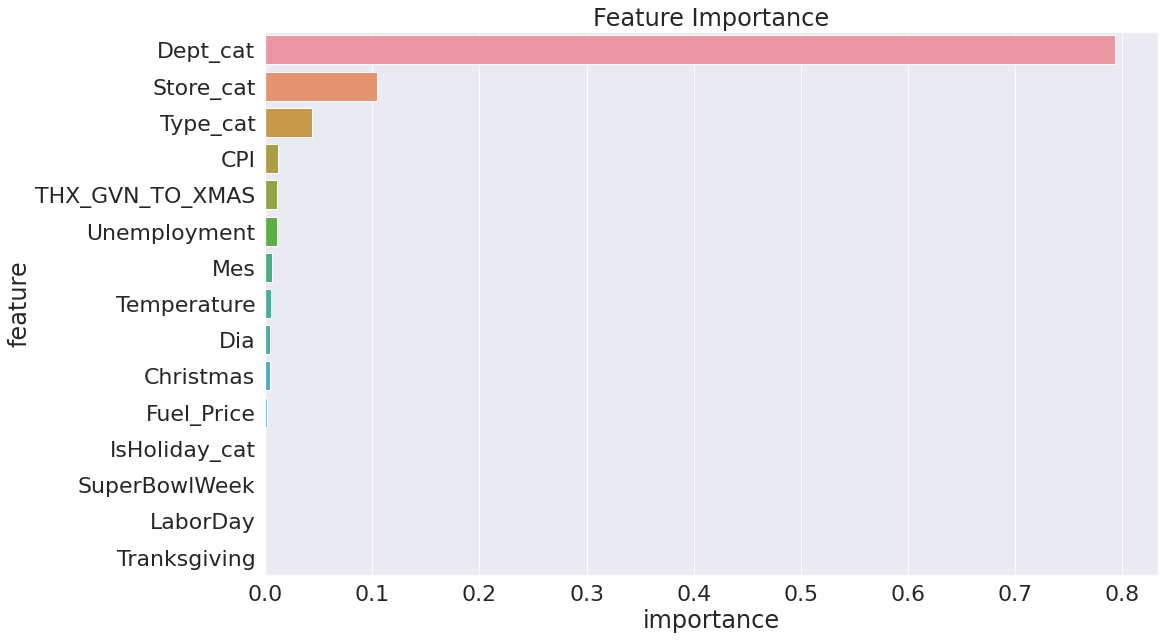

In [94]:
#Plota Feature Importance do Decisio Tree
plota_feature_importance(X_treino,modelo_DT)

É possivel observar que as variaveis Dept, Store e Tipo são as que possuem mais importancia para este modelo

# # RANDOM FOREST

In [95]:
#Testei um numero menor de parametros e sem crossvalidation por falta de tempo e pelas limitações do Kaggle
parameters_RF =   {'n_estimators': [100,150]
                  ,'max_depth': [None]
                  ,'max_features': [0.75]
                  ,"n_jobs":[-1]
                  }

#Treina o modelo Random Forest testando os parametros acima com GridSearch e crossvalidation
modelo_RF,melhor_param_RF =modelos(RandomForestRegressor(),parameters_RF,X_treino,y_treino)

In [96]:
#Escora o modelo
y_pred_treino_RF = modelo_RF.predict(X_treino)
y_pred_val_RF = modelo_RF.predict(X_val)

In [97]:
#Avalia o desempenho
Result_RF=ml_error("RF_Treino", X_treino,y_treino,y_pred_treino_RF,"IsHoliday_cat")
Result_RF=Result_RF.append(ml_error("RF_OOT", X_val,y_val,y_pred_val_RF,"IsHoliday_cat"))
Result_RF

,Model Name,MAE,RMSE,WMAE
0,RF_Treino,504.617499,1226.739440,488.27
0,RF_OOT,1534.369146,3080.080213,1526.88


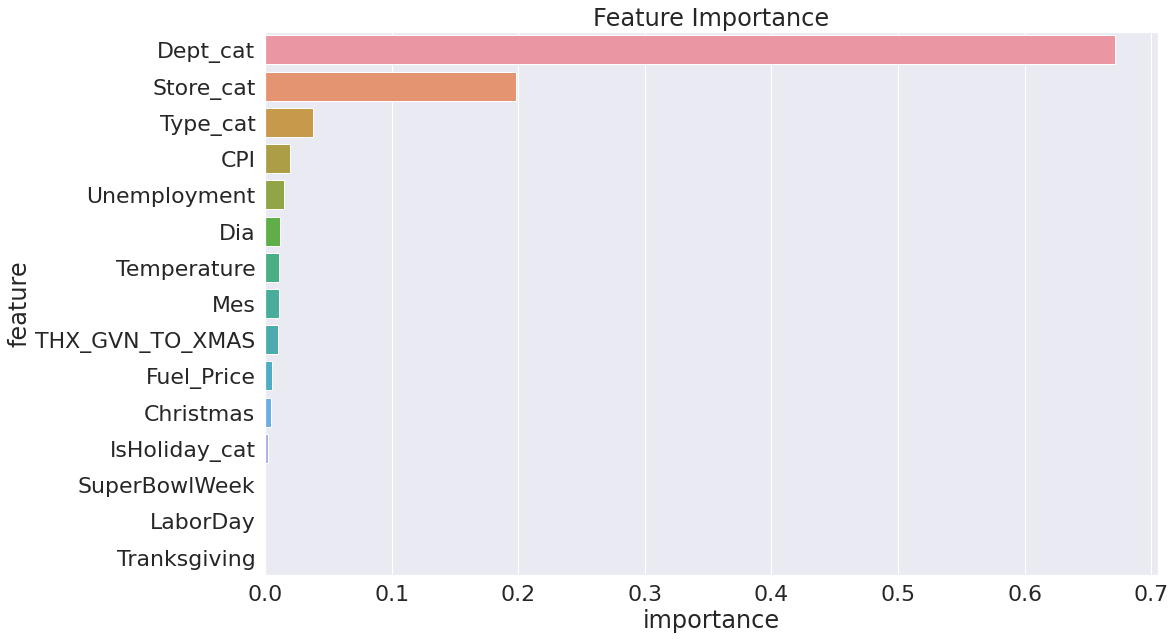

In [98]:
#Plota a Feature importance
plota_feature_importance(X_treino,modelo_RF)

É possivel observar que as variaveis Dept, Store e Tipo são as que possuem mais importancia para este modelo

# # LIGHTGBM

In [99]:
# Este modelo possui a opção de sumeter uma base de validação OOS, entao criei uma função só para ele
# Neste caso nao utilizei crossvalidation por falta de tempo e pelas limitações do Kaggle.
def mod_LGBM(X_treino,Y_treino,X_teste,Y_teste,cv=None):
    from lightgbm import LGBMRegressor,log_evaluation
    from lightgbm import early_stopping
    parameters = {
    "learning_rate": [0.5,0.6,0.7],
    "subsample":[0.75],
    "n_estimators": [150,300,500],
    "max_depth": [15],
    "colsample_bytree":[0.7,0.9],  
    "reg_lambda":[0,1],
    "reg_alpha": [0,1],
       "verbose":[0]
#      "scale_pos_weight": [15],
    #"n_jobs":[-1]
    }    
    eval_set = [(X_treino,Y_treino),(X_teste,Y_teste)]
        
    regressor=LGBMRegressor (objective='regression', seed=0,verbose_eval=False)

    LGBM_grid = GridSearchCV(regressor,parameters,cv=cv)
    LGBM_grid.fit(X_treino,Y_treino
                  ,eval_set=eval_set
                  ,eval_metric=['rmse']
                  ,callbacks=[
                  early_stopping(stopping_rounds=5,first_metric_only=False)
                  ]
                  
                 )

    LGBM_grid.best_params_
    
   
    return LGBM_grid,LGBM_grid.best_params_

In [100]:
#Da base de treino  extraí uma porção para servir de validação OOS  
# Dividindo a base de treino em treino e teste
from sklearn.model_selection import train_test_split
X_treino1, X_val_OOS, y_treino1, y_val_OOS = train_test_split(X_treino # Variáveis Explicativas
                                                    ,y_treino,  # Variável Resposta
                                                    test_size = 0.3, # Proporção entre treino e teste
                                                    random_state = 0)

In [101]:
%%capture
modelo_LGBM,melhor_param_LGBM =mod_LGBM(X_treino1,y_treino1,X_val_OOS,y_val_OOS)

In [102]:
melhor_param_LGBM

{'colsample_bytree': 0.9,
 'learning_rate': 0.5,
 'max_depth': 15,
 'n_estimators': 500,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.75,
 'verbose': 0}

In [103]:
#Escora Modelo LGBM
y_pred_treino_LGBM = modelo_LGBM.predict(X_treino)
y_pred_val_OOS_LGBM = modelo_LGBM.predict(X_val_OOS)
y_pred_val_LGBM = modelo_LGBM.predict(X_val)

In [104]:
#Avalia o desempenho
Result_LGBM=ml_error("LGBM_Treino", X_treino,y_treino,y_pred_treino_LGBM,"IsHoliday_cat")
Result_LGBM=Result_LGBM.append(ml_error("LGBM_OOS", X_val_OOS,y_val_OOS,y_pred_val_OOS_LGBM,"IsHoliday_cat"))
Result_LGBM=Result_LGBM.append(ml_error("LGBM_OOT", X_val,y_val,y_pred_val_LGBM,"IsHoliday_cat"))
Result_LGBM

,Model Name,MAE,RMSE,WMAE
0,LGBM_Treino,1647.195320,2894.833378,1619.15
0,LGBM_OOS,1828.093903,3427.151181,1787.64
0,LGBM_OOT,2198.899406,3830.890337,2188.47


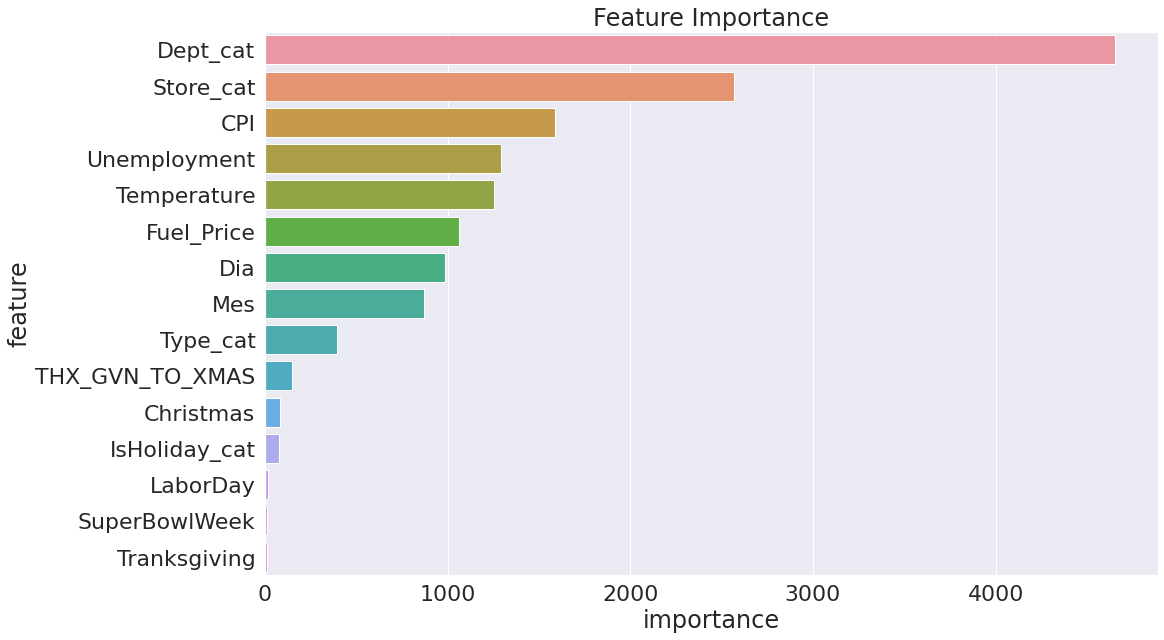

In [105]:
#Plota Feature Importance do LightGBM
plota_feature_importance(X_treino,modelo_LGBM)

No modelo Light GBM podemos observar Dept e Store como as mais importantes, mas diferente de Decision Tree e Random Forest, nesse modelo há uma maior contribuição de fafores externos na perfoemance do modelo,

## Conclusoes 

Como observado na matriz de correlação as variaveis Dept, Store e Tipo são as que possuem mais correlação com a variavel resposta e consequentemente são as mais importantes para este modelo, o que indica uma maior relação das vendas com as caracteristicas dos departamentos/lojas do que com fatores externos. No entanto o modelo Light GBM conseguiu uma performance satisfatória explorando melhor os fatores externos (CPI/Fuel_Price/Unemployment/Temperature).

# AVALIAÇÃO

In [106]:
Resultado = pd.concat([Result_Lasso,Result_DT,Result_RF,Result_LGBM],axis = 0)
Resultado

,Model Name,MAE,RMSE,WMAE
0,LASSO_Treino,10269.777286,16119.229228,10210.21
0,LASSO_OOT,9889.818136,15044.854547,9855.56
0,DT_Treino,1832.911533,5186.216935,1755.07
0,DT_OOT,2144.497528,4308.036458,2132.22
0,RF_Treino,504.617499,1226.739440,488.27
0,RF_OOT,1534.369146,3080.080213,1526.88
0,LGBM_Treino,1647.195320,2894.833378,1619.15
0,LGBM_OOS,1828.093903,3427.151181,1787.64
0,LGBM_OOT,2198.899406,3830.890337,2188.47


Random forest aparentemente apresentou o melhor desempenho em comparação com os outros. Mesmo com um indicio de overfit

Abaixo serão comparados os resultados dos modelos (escora a base_treino) comparados com a variavel resposta

In [107]:
#Esta variavel vou utilizar para agrupar a informação por mes
base_treino["Anomes"]=pd.to_datetime(base_treino['Date']).dt.strftime('%Y%m').astype(int)

In [108]:
base_treino["mod_lasso"] = modelo_lasso.predict(scaler.transform(base_treino[vars_explicativas2]))
base_treino["mod_DT"] = modelo_DT.predict(base_treino[vars_explicativas2])
base_treino["mod_RF"] = modelo_RF.predict(base_treino[vars_explicativas2])
base_treino["mod_LGBM"] = modelo_LGBM.predict(base_treino[vars_explicativas2])


In [109]:
predicted_sales_lasso_mes = base_treino.groupby('Anomes')['mod_lasso'].sum()
predicted_sales_DT_mes= base_treino.groupby('Anomes')['mod_DT'].sum()
predicted_sales_RF_mes=base_treino.groupby('Anomes')['mod_RF'].sum()
predicted_sales_LGBM_mes=base_treino.groupby('Anomesdia')['mod_LGBM'].sum()
Weekly_SALES_mes=base_treino.groupby('Anomes')['Weekly_Sales'].sum()


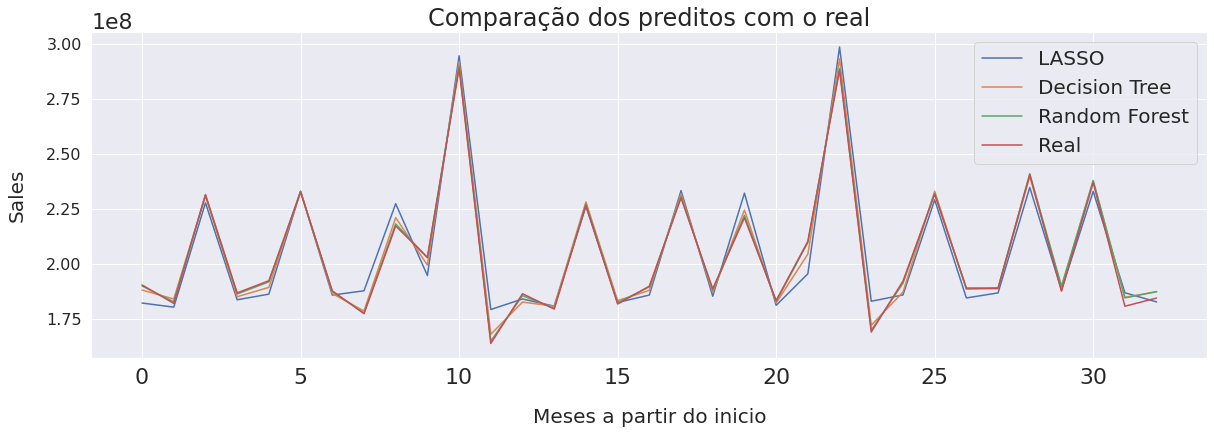

In [110]:
plt.figure(figsize=(20,6))
plt.plot(predicted_sales_lasso_mes.values)
plt.plot(predicted_sales_DT_mes.values)
plt.plot(predicted_sales_RF_mes.values)
plt.plot(Weekly_SALES_mes.values)

# plt.xticks(np.arange(1, 53, step=1), fontsize=16)
plt.yticks( fontsize=16)
plt.ylabel('Sales', fontsize=20, labelpad=20)
plt.xlabel('Meses a partir do inicio', fontsize=20, labelpad=20)

plt.title("Comparação dos preditos com o real", fontsize=24)
plt.legend(['LASSO', 'Decision Tree', 'Random Forest', "Real"], fontsize=20);

In [111]:
predicted_sales_lasso_semana = base_treino.groupby('Date')['mod_lasso'].sum()
predicted_sales_DT_semana= base_treino.groupby('Date')['mod_DT'].sum()
predicted_sales_RF_semana=base_treino.groupby('Date')['mod_RF'].sum()
predicted_sales_LGBM_semana=base_treino.groupby('Date')['mod_LGBM'].sum()
Weekly_SALES_semana=base_treino.groupby('Date')['Weekly_Sales'].sum()

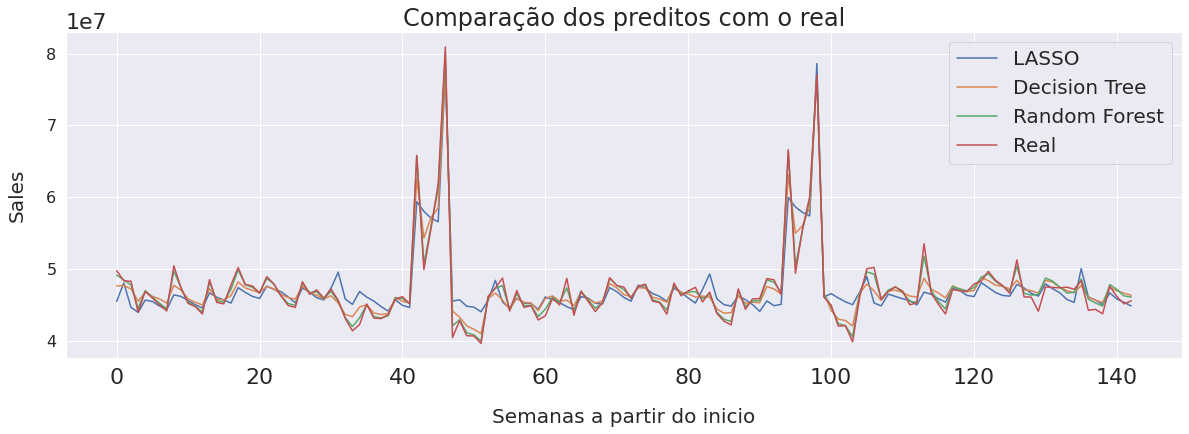

In [112]:
plt.figure(figsize=(20,6))
plt.plot(predicted_sales_lasso_semana.values)
plt.plot(predicted_sales_DT_semana.values)
plt.plot(predicted_sales_RF_semana.values)
plt.plot(Weekly_SALES_semana.values)

# plt.xticks(np.arange(1, 53, step=1), fontsize=16)
plt.yticks( fontsize=16)
plt.ylabel('Sales', fontsize=20, labelpad=20)
plt.xlabel('Semanas a partir do inicio', fontsize=20, labelpad=20)

plt.title("Comparação dos preditos com o real", fontsize=24)
plt.legend(['LASSO', 'Decision Tree', 'Random Forest', "Real"], fontsize=20);

## Escoragem da base Test.csv 

In [113]:
#Faço esta transformação para a variavel date ficar do mesmo tipo de sua correspondente na variavel feature
test['Date'] = pd.to_datetime(test['Date'])

In [114]:
#Cruza base teste com features
base_teste=pd.merge(test,features.drop(columns=["IsHoliday"],axis=1)\
                    ,left_on=["Store","Date"],right_on=["Store","Date"],how="left").merge(stores,left_on=["Store"],right_on=["Store"],how="left")

In [115]:
base_teste.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Anomesdia,Unemployment_norm,CPI_norm,Temperature_norm,Fuel_price_norm,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,20121102,-1.627518,1.237180,-0.820104,0.322212,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,20121109,-1.627518,1.240882,-0.401281,0.139192,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,20121116,-1.627518,1.247197,-0.989898,-0.018408,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,20121123,-1.627518,1.256997,-0.755724,-0.122628,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,20121130,-1.627518,1.266796,-1.030931,-0.132796,A,151315


# IMPLANTAÇÃO

O códigos abaixos são uma proposta para facilitar a implantação do modelo. 
Primeiro criei um classe para transformar JSON em Dataframe. Em seguida criei uma classe para transformar os dados de forma que eles sejam compativeis com o modelo. Depois crio um pipeline que ira pegar a informação crua como input e ira gerar como resultado uma base contendo o escore do modelo


In [116]:
#Transforma JSON em dataframe
import json
class JsonToDF:
    def fit(self, X, y):
        pass
    def transform(self,input_data):
        if type(input_data)==str:
            json_input = str(input_data)
            return pd.json_normalize(json.loads(json_input))
        elif type(input_data) == pd.DataFrame:
            return input_data

In [117]:
#Trata as variaveis cruas e devolve somente as variaveis de interesse do modelo
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class Prep(BaseEstimator,TransformerMixin):

    def __init__(self):
        self.input_vars = ['Date',
                           'Temperature',
                           'Fuel_Price',
                           'CPI', 
                           'Unemployment',
                           'Dept',
                           'Store', 
                           'Type',
                           'IsHoliday']
        
    def transform(self, X):
        
        if(not isinstance(X, pd.DataFrame)):
            X = pd.DataFrame(X, columns=self.input_vars)
            
            
        fill_missings = {'SuperBowlWeek':0,
                             'LaborDay':0,
                             'Tranksgiving':0,
                             'Christmas':0,
                             "THX_GVN_TO_XMAS":0,
                             
                             'IsHoliday_cat':0,
                             "Type_cat":1,
                             "Store_cat":22,
                             "Dept_cat":40,
    
                             "CPI":182.7,
                             "Temperature":60.7,
                             "Fuel_Price":3.51,
                             "Unemployment":7.8               
                            }
        
        self.final_vars=[
           'Mes',
           'Dia', 
           'Temperature',
           'Fuel_Price',
           'CPI', 
           'Unemployment',
           'Dept_cat', 'Store_cat', 'Type_cat',
           'IsHoliday_cat', 
           'SuperBowlWeek', 'LaborDay', 'Tranksgiving', 'Christmas',
           'THX_GVN_TO_XMAS']

        map_Dept={'92': 1, '95': 2, '38': 3, '65': 4, '72': 5, '40': 6, '2': 7,\
                  '90': 8, '94': 9, '91': 10, '8': 11, '13': 12, '93': 13, '4': 14,\
                  '23': 15, '79': 16, '7': 17, '46': 18, '5': 19, '10': 20, '9': 21,\
                  '1': 22, '34': 23, '82': 24, '96': 25, '97': 26, '11': 27, '14': 28,\
                  '81': 29, '74': 30, '80': 31, '87': 32, '17': 33, '3': 34, '22': 35,\
                  '55': 36, '25': 37, '49': 38, '16': 39, '98': 40, '26': 41, '67': 42, \
                  '32': 43, '33': 44, '24': 45, '42': 46, '20': 47, '71': 48, '29': 49, \
                  '21': 50, '44': 51, '6': 52, '12': 53, '30': 54, '37': 55, '83': 56,\
                  '35': 57, '58': 58, '50': 59, '31': 60, '85': 61, '52': 62, '56': 63, \
                  '36': 64, '19': 65, '27': 66, '41': 67, '18': 68, '48': 69, '28': 70, \
                  '59': 71, '60': 72, '77': 73, '99': 74, '54': 75, '47': 76, '45': 77, '51': 78, '39': 79, '78': 80, '43': 81}

        map_Store={'20': 1, '14': 2, '4': 3, '2': 4, '13': 5, '10': 6, '6': 7, '27': 8,\
                   '19': 9, '11': 10, '23': 11, '39': 12, '28': 13, '24': 14, '1': 15, \
                   '18': 16, '35': 17, '41': 18, '31': 19, '22': 20, '12': 21, '32': 22,\
                   '8': 23, '26': 24, '40': 25, '17': 26, '21': 27, '34': 28, '45': 29,\
                   '25': 30, '15': 31, '29': 32, '7': 33, '9': 34, '16': 35, '3': 36, \
                   '5': 37, '36': 38, '43': 39, '37': 40, '42': 41, '30': 42, '33': 43, '44': 44, '38': 45}

        map_Type={'A': 1, 'B': 2, 'C': 3}

        X["Dept_cat"]=X["Dept"].astype(str).map(map_Dept).astype(float)
        X["Store_cat"]=X["Store"].astype(str).map(map_Store).astype(float)
        X["Type_cat"]=X["Type"].astype(str).map(map_Type).astype(float)
        
        X.fillna(fill_missings, inplace=True)

        X['Date'] = pd.to_datetime(X['Date'])
        X['Ano'] = (X.Date.dt.year).astype(int)
        X['Mes'] = (X.Date.dt.month).astype(int)
        X['Dia'] = (X.Date.dt.day).astype(int)
        X['SemanaDoAno'] = ((X.Date.dt.isocalendar().week)*1.0).astype(int) 


        X['IsHoliday_cat'] = X['IsHoliday'].apply(lambda x: 1 if x else 0)

        X['SuperBowlWeek'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 6 else 0)
        X['LaborDay'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 35 else 0)
        X['Tranksgiving'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 46 else 0)
        X['Christmas'] = base_treino['SemanaDoAno'].apply(lambda x: 1 if x == 51 else 0)
        X["THX_GVN_TO_XMAS"]=base_treino['SemanaDoAno'].apply(lambda x: 1 if (x>46) & (x<52)  else 0)

        return X[self.final_vars]

In [118]:
#Chama as classes
prep=Prep()
jsontodf=JsonToDF()

In [119]:
#Cria o pipeline para tratamento e escoragem
p=Pipeline(steps=[("transform",jsontodf),("prep",prep),("modelo",modelo_RF)])

## Submissão

In [120]:
#Submete
sample_submission['Weekly_Sales'] = p.predict(base_teste)
sample_submission.to_csv('submission.csv',index=False)
sample_submission.to_csv('/kaggle/working/submission.csv',index=False)

# PONTOS DE MELHORIA


- Fazer um modelo para cada tipo ("Type") de loja pode melhorar a performance.

- Utilização do cross validation e maior quantidade de parametros para os modelos mais complexos, que demandam maior capadicade computacional e tempo.

- Feriados no geral são muito importantes para as vendas. Faria sentido incluir outros feriados que não constam nas bases e testar

- Realizar uma melhor exploração de Markdowns com mais tempo observando os periodos antes e depois dos markdowns
